In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [14]:
df = pd.read_csv("SORCE_solar_irradiance_1-400nm.csv")
wavelength = np.array(df["wavelength (nm)"].tolist())
irradiance = np.array(df["irradiance (W/m^2/nm)"].tolist())
irradiance_err = np.array(df["uncertainty (W/m^2/nm)"].tolist())
df.head()

,wavelength (nm),irradiance (W/m^2/nm),uncertainty (W/m^2/nm),Unnamed: 3,Unnamed: 4
0,1.5,0.000072,0.050974,NaN,NaN
1,2.5,0.000056,0.050974,NaN,NaN
2,3.5,0.000046,0.050974,NaN,NaN
3,4.5,0.000054,0.050974,NaN,NaN
4,5.5,0.000071,0.050974,NaN,NaN


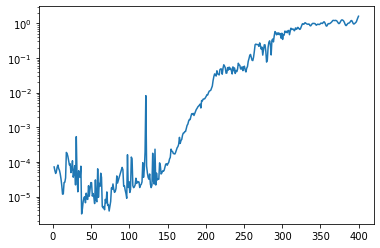

In [16]:
plt.plot(wavelength,irradiance)
plt.yscale("log")